# TUNEL Oakwood vypocet V

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
import random
import re
import os

from scipy import stats as sc
from scipy.stats import lognorm, norm

from sklearn.model_selection import train_test_split

from colorama import Fore, Style
from termcolor import colored
try:
    from UQpy import surrogates, sensitivity, distributions
    from UQpy.surrogates import PolynomialChaosExpansion, TotalDegreeBasis
    from UQpy.sensitivity import PceSensitivity
    from UQpy.distributions import Uniform, Normal, Lognormal, JointIndependent
    from UQpy.surrogates.polynomial_chaos.polynomials.baseclass.Polynomials import Polynomials
    from UQpy.surrogates.polynomial_chaos.regressions.LeastSquareRegression import LeastSquareRegression
    UQPY_AVAILABLE = True
except Exception as e:
    UQPY_AVAILABLE = False
    UQPY_IMPORT_ERROR = e

# Nastavení
target_error = 1  # cílová chyba modelu
CheckOverfitting = True  # kontrola přeučení modelu
least_squares = LeastSquareRegression()  # metoda regrese pokud dostupná

print("Dostupnost UQpy:", UQPY_AVAILABLE)

Dostupnost UQpy: True


## Načtení dat

In [43]:
df = pd.read_excel("V.xlsx", sheet_name=0, header=0)

# Úprava exelu
drop_candidates = [c for c in df.columns if str(c).strip().lower() in ["analysis", "id", "index", "unnamed: 0"]]
df = df.drop(columns=drop_candidates, errors="ignore")
df.columns = [str(c).strip() for c in df.columns]

# Detekce prvního výstupního sloupce
first_u_mask = df.columns.str.startswith("U_") | df.columns.str.startswith("SF_")
if not first_u_mask.any():
    raise RuntimeError("Nebyly nalezeny výstupy 'U_' nebo 'SF_'.")

first_u_col = df.columns[first_u_mask][0]

# Rozdělení na vstupy a výstupy
param_columns = df.columns[:df.columns.get_loc(first_u_col)]
df_params = df[param_columns].apply(pd.to_numeric, errors="coerce")
df_u = df.loc[:, first_u_col:].apply(pd.to_numeric, errors="coerce")

# Uložím vstupy a výstupy do zvlášt souborů
df_params.to_csv("V_parameters.csv", index=False)
df_u.to_csv("V_outputs.csv", index=False)

# Zkladní statistiky
df_float = df.apply(pd.to_numeric, errors="coerce")
mean_values = df_float.mean(axis=0)
std_deviations = df_float.std(axis=0, ddof=1)
results_df = pd.DataFrame({"Sloupec": df.columns, "Průměr": mean_values.values, "Směrodatná odchylka": std_deviations.values})
results_df.to_csv("V_summary_stats.csv", index=False)

df.head(), df_params.shape, df_u.shape

(     Ec   Rel  Erat_1  E50_1   c_1  phi_1  k0_1  Erat_2  E50_2  c_2  ...  \
 0   NaN   NaN     NaN    NaN   NaN    NaN   NaN     NaN    NaN  NaN  ...   
 1   NaN   NaN     NaN    NaN   NaN    NaN   NaN     NaN    NaN  NaN  ...   
 2  12.0  53.0     2.2   74.0  22.0   30.0  0.62     2.8  130.0  4.3  ...   
 3  14.0  46.0     2.4   60.0  31.0   30.0  0.98     2.0  140.0  3.8  ...   
 4  12.0  44.0     3.0   77.0  31.0   30.0  1.00     2.8  140.0  6.5  ...   
 
    SF_6662_19  SF_6661_19  SF_6660_19  SF_6659_19  SF_6658_19  SF_6657_19  \
 0         NaN         NaN         NaN         NaN         NaN         NaN   
 1         NaN         NaN         NaN         NaN         NaN         NaN   
 2    68596.78   56763.055    43583.38   31364.498   20984.627   13186.713   
 3    74997.57   65590.810    53300.70   40869.277   29583.000   20462.635   
 4    75566.10   64063.957    50694.40   37988.330   26873.857   18114.363   
 
    SF_6656_19  SF_6655_19  SF_6654_19  SF_6653_19  
 0         Na

## Výpočet PCE

In [44]:
# Definice vstupních distribucí
input_distributions = [
    Normal(loc=13, scale=1),         # Ec (GPa)
    Uniform(loc=30, scale=40),       # Rel % 
    Uniform(loc=2, scale=1),         # Erat_1 
    Normal(loc=65, scale=5),         # E50_1 (kPa)
    Normal(loc=30, scale=5),         # c_1 (kPa)
    Normal(loc=30, scale=1),         # phi_1 (deg)
    Uniform(loc=0.6, scale=0.5),     # k0_1 
    Uniform(loc=2, scale=1),         # Erat_2
    Normal(loc=130, scale=10),       # E50_2 (kPa)
    Normal(loc=5, scale=1),          # c_2 (kPa)
    Normal(loc=42, scale=1),         # phi_2 (deg)
    Uniform(loc=0.45, scale=0.2)     # k0_2
] if UQPY_AVAILABLE else []

joint = JointIndependent(marginals=input_distributions)

n_cols = len(df_u.columns)

In [45]:
# Nastavení modelu
nsim_values = [50, 75, 100] # počet vstupu do PCE
n_runs_per_setting = 2  # kolikrat projede PCE se stejnym nsim 

# Kontrola pro nsim
nsim_values = [n for n in nsim_values if n < len(df_params)]
if len(nsim_values) == 0:
    raise ValueError("Žádná hodnota nsim není menší než počet řádků")

def pce_runs(nsim_cur: int, n_runs_local: int):
    """Spustí PCE. Vrací list DataFrame 'run_results' (jeden DF na průchod) – obsahuje i Sobol' indexy S1/ST. """
    results_all_runs = []

    for run in range(n_runs_local):
        print(f"\n[nsim={nsim_cur}] Průchod {run+1}/{n_runs_local}")

        # náhodný výběr pro trénink
        if nsim_cur > len(df_params):
            raise ValueError(f"nsim ({nsim_cur}) je větší než počet dostupných řádků ({len(df_params)}).")
        random_indices = random.sample(range(len(df_params)), nsim_cur)

        train_indices = random_indices
        val_indices = sorted(set(range(len(df_params))) - set(train_indices))

        X_train = df_params.iloc[train_indices].values # vstupy pro trénink
        Y_train = df_u.iloc[train_indices].values # vystup
        X_val = df_params.iloc[val_indices].values if len(val_indices) > 0 else None # vstupy validace
        Y_val = df_u.iloc[val_indices].values if len(val_indices) > 0 else None # vystup

        n_cols = len(df_u.columns)
        n_inputs = X_train.shape[1]

        best_error = np.full(n_cols, np.nan)     # LOO nejlepšího modelu
        best_val_error = np.full(n_cols, np.nan) # hold-out nejlepšího modelu
        best_mean = np.full(n_cols, np.nan)
        best_std = np.full(n_cols, np.nan)
        best_params = [None] * n_cols

        # Sobolovy indexy
        sobol_first = [None] * n_cols  # S1: pro danou veličinu
        sobol_total = [None] * n_cols  # ST: totální

        # metriky LAR
        err_lar = np.full(n_cols, np.nan)    # LOO LAR
        err_full = np.full(n_cols, np.nan)   # LOO full
        val_lar = np.full(n_cols, np.nan)    # hold-out LAR
        val_full = np.full(n_cols, np.nan)   # hold-out full

        # Iniciace proměnných
        for i, col in enumerate(df_u.columns):  # projdi všechny výstupy
            Y_col_train = Y_train[:, i].reshape(-1, 1)
            Y_col_val = (Y_val[:, i].reshape(-1, 1) if Y_val is not None else None)

            if np.allclose(Y_col_train, Y_col_train[0], atol=1e-12):
                best_params[i] = (1, 1.0)
                best_error[i] = best_val_error[i] = 0.0
                best_mean[i] = float(Y_col_train[0])
                best_std[i] = 0.0
                sobol_first[i] = np.zeros(n_inputs)
                sobol_total[i] = np.zeros(n_inputs)
                err_lar[i] = err_full[i] = val_lar[i] = val_full[i] = 0.0
                continue

            best_err = np.inf
            best_model = None

            # PCE
            for p in range(3, 4):
                for q in [0.6, 0.8, 1.0]:
                    try:
                        basis = TotalDegreeBasis(joint, p, hyperbolic=q)
                        if basis.polynomials_number >= 0.9 * len(X_train):
                            continue

                        pce = PolynomialChaosExpansion(polynomial_basis=basis, regression_method=least_squares)
                        pce.fit(X_train, Y_col_train)

                        # LAR
                        try:
                            from UQpy.surrogates.polynomial_chaos.regressions import LeastAngleRegression  #Pro jistotu
                            lar = LeastAngleRegression.model_selection(pce, target_error, CheckOverfitting)
                            e_lar = lar.leaveoneout_error()
                            v_lar = lar.validation_error(X_val, Y_col_val) if Y_col_val is not None else np.nan
                        except Exception:
                            e_lar = np.inf; v_lar = np.nan                            

                        # Full PCE
                        try:
                            e_full = pce.leaveoneout_error()
                            v_full = pce.validation_error(X_val, Y_col_val) if Y_col_val is not None else np.nan
                        except Exception:
                            e_full = np.inf; v_full = np.nan

                        # uloží pro aktuální p,q
                        err_lar[i] = e_lar if np.isfinite(e_lar) else np.nan
                        err_full[i] = e_full if np.isfinite(e_full) else np.nan
                        val_lar[i] = v_lar if np.isfinite(v_lar) else np.nan
                        val_full[i] = v_full if np.isfinite(v_full) else np.nan

                        # vý nejlepšího modelu podle LOO
                        chosen, e = (lar, e_lar) if e_lar < e_full else (pce, e_full)
                        if np.isfinite(e) and e < best_err:
                            best_err = e
                            best_model = chosen
                            best_params[i] = (p, q)
                            best_error[i] = e
                            best_val_error[i] = v_lar if chosen is lar else v_full

                    except Exception as exc:
                        print(f"  Error p={p}, q={q} → {exc}")
                        continue

            if best_model is not None:
                # momenty z PCE
                m, v = best_model.get_moments()
                best_mean[i] = float(m)
                best_std[i] = float(np.sqrt(v))
                # Sobol' indexy z PCE
                sens = PceSensitivity(best_model); sens.run()
                sobol_first[i] = np.asarray(sens.first_order_indices, dtype=float)  # S1 (size = n_inputs)
                sobol_total[i] = np.asarray(sens.total_order_indices, dtype=float)  # ST (size = n_inputs)

        # DF s výsledky pro jeden průchod (+ Sobol indexy S1/ST jako vektory)
        run_results = pd.DataFrame({
            'column': df_u.columns,
            'p': [bp[0] if bp else None for bp in best_params],
            'q': [bp[1] if bp else None for bp in best_params],
            'LOO_best': best_error,
            'Val_best': best_val_error,
            'mean_PCE': best_mean,
            'std_PCE': best_std,
            'LOO_LAR': err_lar,
            'LOO_full': err_full,
            'Val_LAR': val_lar,
            'Val_full': val_full,
            'S1': [sf if sf is not None else np.full(n_inputs, np.nan) for sf in sobol_first],
            'ST': [st if st is not None else np.full(n_inputs, np.nan) for st in sobol_total],
        })
        results_all_runs.append(run_results)

    return results_all_runs

## Práce s výsledky


[nsim=50] Průchod 1/2
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear Least Squares
  Error p=3, q=0.6 → SVD did not converge in Linear L

,nsim,mean_error,std_error,runs
0,50,0.049198,NaN,2
1,75,0.059834,0.005747,2
2,100,0.052606,NaN,2


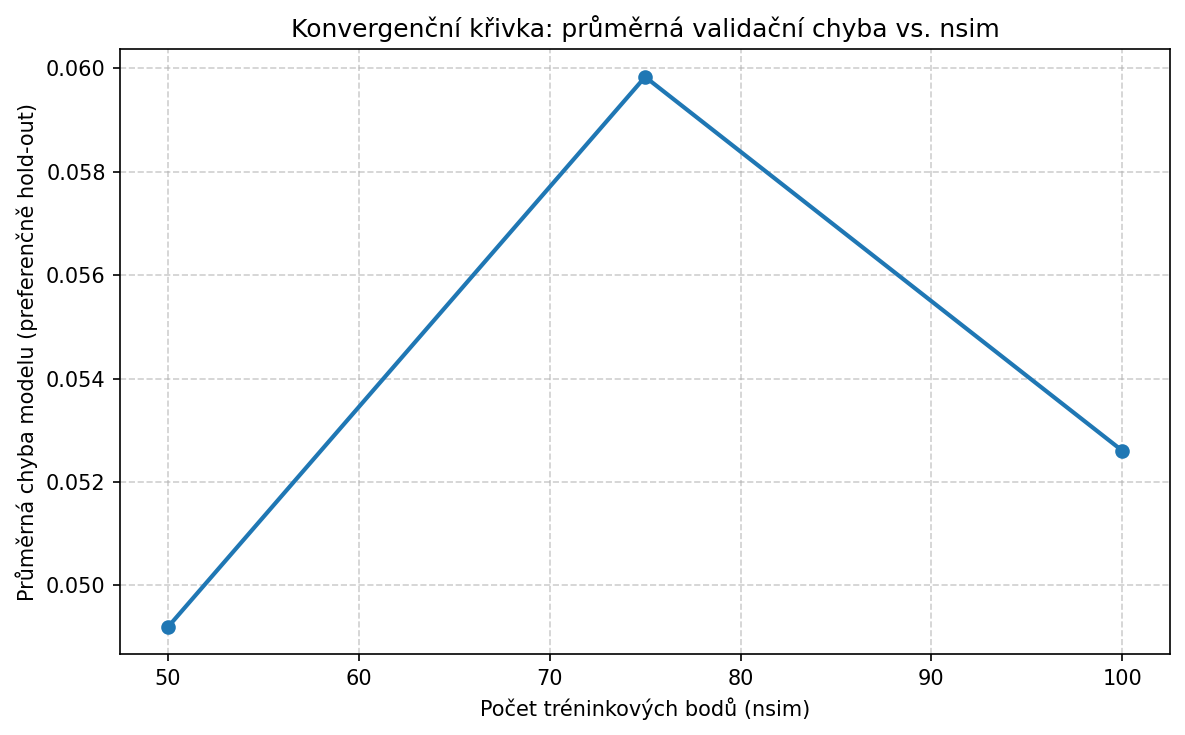

,column,mean_LOO_best,mean_Val_best,mean_mean_PCE,mean_std_PCE,mean_LOO_LAR,mean_LOO_full,mean_Val_LAR,mean_Val_full,S1_Ec,...,S1_Erat_2,ST_Erat_2,S1_E50_2,ST_E50_2,S1_c_2,ST_c_2,S1_phi_2,ST_phi_2,S1_k0_2,ST_k0_2
0,SF_6652_19,0.288787,NaN,1069.483309,185.589715,0.288787,0.838161,NaN,NaN,0.477200,...,0.006416,0.006416,0.012572,0.012572,0.012076,0.012076,0.008947,0.008947,0.353907,0.353907
1,SF_6651_19,0.096575,NaN,-670.082553,693.945412,0.096575,0.273800,NaN,NaN,0.536153,...,0.006007,0.006007,0.006661,0.006661,0.001541,0.001541,0.004426,0.004426,0.029440,0.029440
2,SF_6650_19,0.076322,NaN,-3460.732920,1233.098459,0.076322,0.214653,NaN,NaN,0.514808,...,0.006571,0.006571,0.006644,0.006644,0.000977,0.000977,0.001105,0.001105,0.005366,0.005366
3,SF_6649_19,0.064333,NaN,-7942.532354,1768.682382,0.064333,0.186360,NaN,NaN,0.470317,...,0.012356,0.012356,0.007338,0.007338,0.000907,0.000907,0.000666,0.000666,0.000610,0.000610
4,SF_6648_19,0.057820,NaN,-14604.680392,2296.821950,0.057820,0.166092,NaN,NaN,0.431628,...,0.017472,0.017472,0.009639,0.009639,0.000716,0.000716,0.000941,0.000941,0.002003,0.002003


In [46]:
conv_rows = []
conv_details = []  
all_results = []   # akumulace všech run_results napříč nsim

for ns in nsim_values:
    run_list = pce_runs(ns, n_runs_per_setting)
    all_results.extend(run_list)

    # průměrná chyba za 1 průchod
    per_run_mean_errors = []
    for rr in run_list:
        val = rr['Val_best'].values
        loo = rr['LOO_best'].values
        mix = np.where(np.isfinite(val), val, loo)
        per_run_mean_errors.append(np.nanmean(mix))

    mean_err = float(np.nanmean(per_run_mean_errors)) if len(per_run_mean_errors) else np.nan
    std_err  = float(np.nanstd(per_run_mean_errors, ddof=1)) if len(per_run_mean_errors) > 1 else np.nan
    conv_rows.append({'nsim': ns, 'mean_error': mean_err, 'std_error': std_err, 'runs': len(per_run_mean_errors)})
    conv_details.append({'nsim': ns, 'per_run_mean_errors': per_run_mean_errors})

# Výsledkový DF a uložení
conv_df = pd.DataFrame(conv_rows).sort_values('nsim').reset_index(drop=True)
display(conv_df)
conv_df.to_csv("V_convergence.csv", index=False)

# Vykreslení konvergenční křivky
plt.figure(figsize=(8, 5))
plt.plot(conv_df['nsim'], conv_df['mean_error'], marker='o', linewidth=2)
plt.xlabel('Počet tréninkových bodů (nsim)')
plt.ylabel('Průměrná chyba modelu (preferenčně hold-out)')
plt.title('Konvergenční křivka: průměrná validační chyba vs. nsim')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("V_convergence_curve.png", dpi=200)
plt.show()

#Spojení výsledků

if len(all_results) > 0:
    cols_out = list(df_u.columns)       # výstupy PCE
    cols_in  = list(df_params.columns)  # vstupy (parametry)

    # Složení 2D metrik do tvaru a průměr přes osu 0
    def _stack_metric(metric):
        mats = []
        for rr in all_results: 
            s = pd.Series(rr[metric].values, index=rr['column'])
            s = s.reindex(cols_out)
            mats.append(s.values)
        return np.vstack(mats) if len(mats) else None

    arr_LOO_best = _stack_metric('LOO_best')
    arr_Val_best = _stack_metric('Val_best')
    arr_mean_PCE = _stack_metric('mean_PCE')
    arr_std_PCE  = _stack_metric('std_PCE')
    arr_LOO_LAR  = _stack_metric('LOO_LAR')
    arr_LOO_full = _stack_metric('LOO_full')
    arr_Val_LAR  = _stack_metric('Val_LAR')
    arr_Val_full = _stack_metric('Val_full')

    mean_results = pd.DataFrame({
        'column': cols_out,
        'mean_LOO_best': np.nanmean(arr_LOO_best, axis=0),
        'mean_Val_best': np.nanmean(arr_Val_best, axis=0),
        'mean_mean_PCE': np.nanmean(arr_mean_PCE, axis=0),
        'mean_std_PCE':  np.nanmean(arr_std_PCE,  axis=0),
        'mean_LOO_LAR':  np.nanmean(arr_LOO_LAR,  axis=0),
        'mean_LOO_full': np.nanmean(arr_LOO_full, axis=0),
        'mean_Val_LAR':  np.nanmean(arr_Val_LAR,  axis=0),
        'mean_Val_full': np.nanmean(arr_Val_full, axis=0),
    })

    # Sobol– průměr přes běhy po vstupech 
    s1_stack = []
    st_stack = []
    for rr in all_results:
        S1_mat = np.vstack([np.asarray(x, dtype=float).ravel() for x in rr['S1'].to_numpy()])
        ST_mat = np.vstack([np.asarray(x, dtype=float).ravel() for x in rr['ST'].to_numpy()])

# teď má mít S1_mat tvar (len(rr), n_samples)
        assert S1_mat.shape[0] == len(rr)
        S1_df = pd.DataFrame(S1_mat, index=rr['column'])
        ST_df = pd.DataFrame(ST_mat, index=rr['column'])
        S1_df.columns = [f"s{i+1}" for i in range(S1_df.shape[1])]
        ST_df.columns = [f"s{i+1}" for i in range(ST_df.shape[1])]
        s1_stack.append(S1_df.to_numpy()) 
        st_stack.append(ST_df.to_numpy())

    S1_all = np.stack(s1_stack, axis=0)  # (n_runs_total, n_out, n_in)
    ST_all = np.stack(st_stack, axis=0)  # (n_runs_total, n_out, n_in)

    # průměr přes běhy -> (n_out, n_in)
    S1_mean = np.nanmean(S1_all, axis=0)
    ST_mean = np.nanmean(ST_all, axis=0)

    # přidej do mean_results sloupce S1_<input> a ST_<input> (po vstupech)
    for j, in_name in enumerate(cols_in):
        mean_results[f'S1_{in_name}'] = S1_mean[:, j]
        mean_results[f'ST_{in_name}'] = ST_mean[:, j]

    # uložení do CSV (včetně Sobol indexů ve stejném souboru)
    mean_results.to_csv("V_mean_results.csv", index=False)
    display(mean_results.head())
else:
    print("Mean results neexistují (PCE neproběhlo nebo chybí all_results).")

# =================== KONEC KONVERGENČNÍ KŘIVKY =====================

### Vykreslení chyby v %

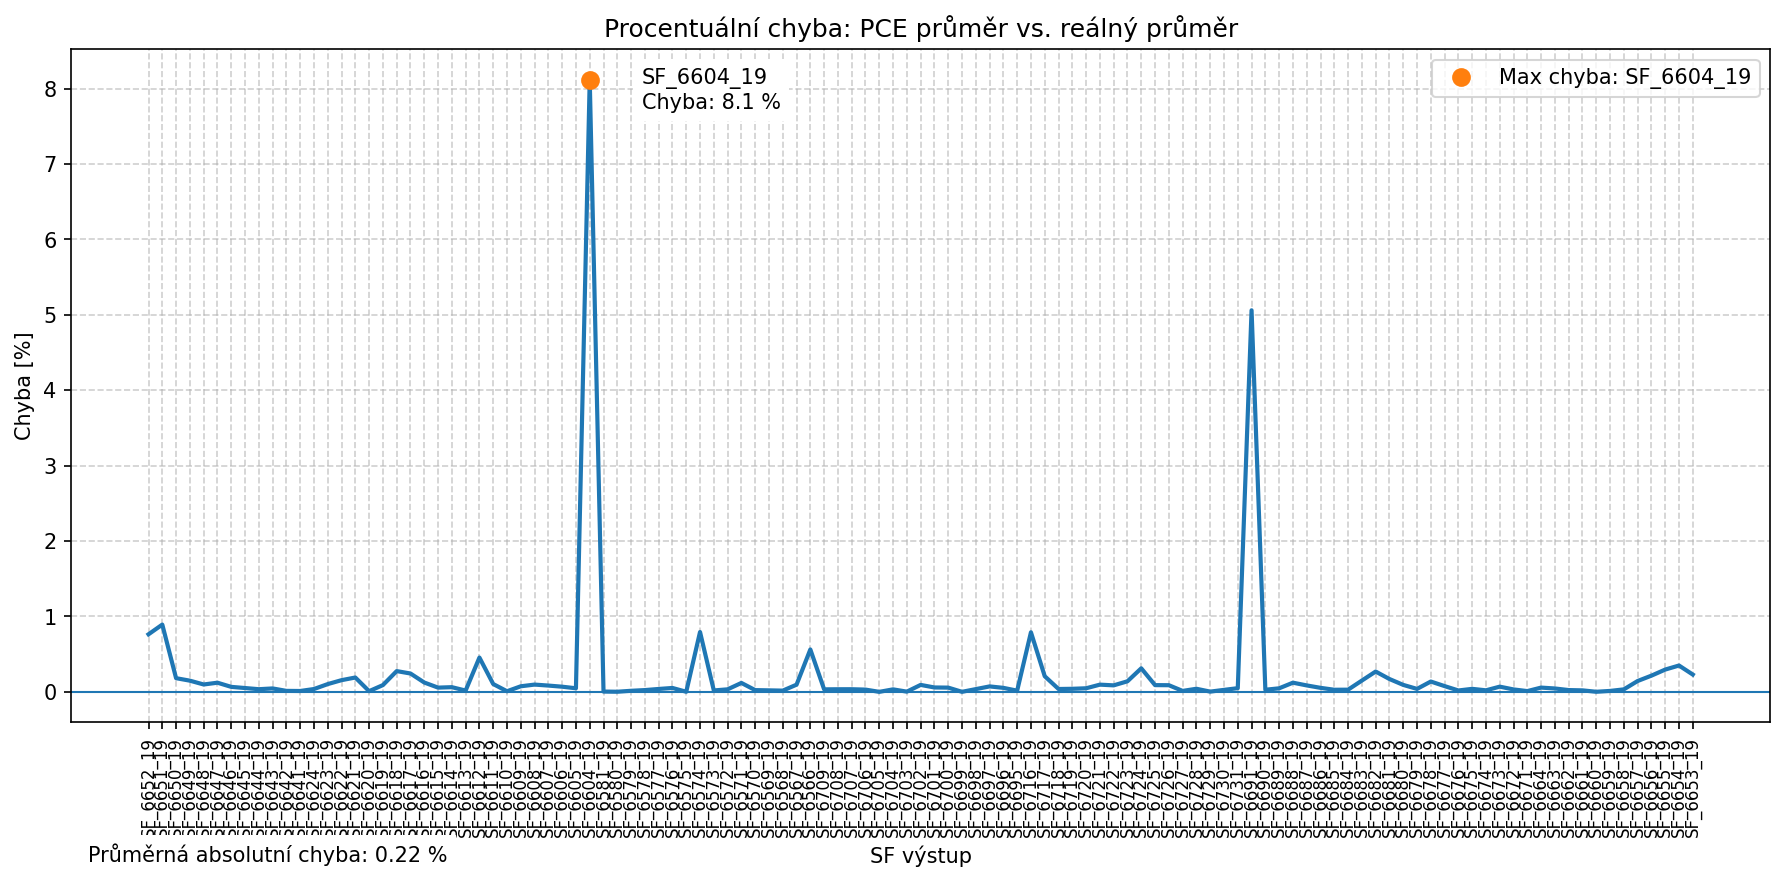

Uloženo do: V_error_percent_line.png


In [47]:
# nastavení
only_sf = True
EPS = 1e-9
outfile = "V_error_percent_line.png"

all_out_cols = list(df_u.columns)
sf_cols_auto = [c for c in all_out_cols if str(c).startswith("SF_")]
use_cols = sf_cols_auto if (only_sf and len(sf_cols_auto) > 0) else all_out_cols
true_means = df_u[use_cols].apply(pd.to_numeric, errors="coerce").mean(axis=0)

# příprava predikcí a společných sloupců
pred_map = mean_results.set_index("column")["mean_mean_PCE"]
common_cols = [c for c in use_cols if c in pred_map.index]
true_vec = true_means.reindex(common_cols).to_numpy(dtype=float)
pred_vec = pred_map.reindex(common_cols).to_numpy(dtype=float)

# výpočet procentuální chyby
den = np.maximum(np.abs(true_vec), EPS)
err_pct = 100.0 * np.abs(pred_vec - true_vec) / den
mean_abs_err = float(np.nanmean(np.abs(err_pct)))
max_idx = int(np.nanargmax(err_pct))
max_x, max_y, max_label = max_idx, float(err_pct[max_idx]), common_cols[max_idx]

# vykreslení grafu
plt.rcParams.update({"figure.dpi": 150})
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(common_cols))
ax.plot(x, err_pct, linewidth=2)
ax.axhline(0.0, linewidth=1)
ax.plot(max_x, max_y, 'o', markersize=8, label=f"Max chyba: {max_label}")
ax.annotate(f"{max_label}\nChyba: {max_y:.1f} %", xy=(max_x, max_y), xytext=(25, -5),
            textcoords="offset points", va="center", ha="left",
            bbox=dict(facecolor="white", alpha=1, edgecolor="none"), clip_on=False)
ax.text(0.01, -0.18, f"Průměrná absolutní chyba: {mean_abs_err:.2f} %",
        transform=ax.transAxes, fontsize=10, va="top", ha="left",
        bbox=dict(facecolor="white", alpha=1, edgecolor="none"), clip_on=False)

# popisky a uložení
ax.set_xlabel("SF výstup" if (only_sf and len(sf_cols_auto) > 0) else "Výstup")
ax.set_ylabel("Chyba [%]")
ax.set_title("Procentuální chyba: PCE průměr vs. reálný průměr")
ax.set_xticks(x)
ax.set_xticklabels(common_cols, rotation=90, fontsize=8)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(loc="best")
fig.tight_layout()
fig.savefig(outfile, dpi=300)
plt.show()
print(f"Uloženo do: {outfile}")


### Sobol indexy

In [48]:
nodes = np.array([
    (0, -10.5275), (0.492, -10.5395), (0.983, -10.5755), (1.4719, -10.6353),
    (1.95708, -10.719), (2.43761, -10.8261), (2.91235, -10.9566), (3.38016, -11.1101),
    (3.83994, -11.2861), (4.29059, -11.4844), (4.73104, -11.7044), (5.16024, -11.9456),
    (5.57717, -12.2075), (6.00215, -12.505), (6.41129, -12.824), (6.80351, -13.1636),
    (7.17776, -13.5229), (7.53, -13.901), (7.87, -14.2968), (8.18, -14.7093),
    (8.48, -15.1374), (8.74685, -15.58), (8.97931, -16.0164), (9.18182, -16.4675),
    (9.35346, -16.9312), (9.49344, -17.4055), (9.60113, -17.8881), (9.67604, -18.3768),
    (9.71783, -18.8695), (9.7263, -19.3639), (9.70142, -19.8578), (9.64331, -20.3488),
    (9.55222, -20.8348), (9.42857, -21.3136), (9.27246, -21.7842), (9.08488, -22.2431),
    (8.86671, -22.6884), (8.61894, -23.1179), (8.34143, -23.5199), (8.02741, -23.8942),
    (7.67966, -24.2374), (7.30124, -24.5464), (6.89548, -24.8185), (6.46599, -25.0513),
    (6.01653, -25.2428), (5.55109, -25.3913), (5.07787, -25.5123), (4.60202, -25.6225),
    (4.12377, -25.7219), (3.6434, -25.8104), (3.16338, -25.8875), (2.68174, -25.9538),
    (2.19873, -26.0091), (1.71458, -26.0534), (1.22955, -26.0868), (0.744, -26.1092),
    (0.258, -26.1205), (-0.228, -26.1209), (-0.714, -26.1102), (-1.20007, -26.0885),
    (-1.68514, -26.0558), (-2.16935, -26.0121), (-2.65244, -25.9574), (-3.13417, -25.8919),
    (-3.61429, -25.8154), (-4.10204, -25.7262), (-4.58759, -25.6257), (-5.07, -25.5141),
    (-5.55, -25.3913), (-6.01653, -25.2428), (-6.47, -25.0513), (-6.90, -24.8185),
    (-7.30124, -24.5464), (-7.67966, -24.2374), (-8.02741, -23.8942), (-8.34143, -23.5199),
    (-8.61894, -23.1179), (-8.86671, -22.6884), (-9.08488, -22.2431), (-9.27246, -21.7842),
    (-9.42857, -21.3136), (-9.55222, -20.8348), (-9.64331, -20.3488), (-9.70142, -19.8578),
    (-9.7263, -19.3639), (-9.71783, -18.8695), (-9.67604, -18.3768), (-9.60113, -17.8881),
    (-9.49344, -17.4055), (-9.35346, -16.9312), (-9.18182, -16.4675), (-8.97931, -16.0164),
    (-8.74685, -15.58), (-8.47618, -15.1374), (-8.18314, -14.7093), (-7.86849, -14.2968),
    (-7.53307, -13.901), (-7.17776, -13.5229), (-6.80351, -13.1636), (-6.41129, -12.824),
    (-6.00215, -12.505), (-5.57717, -12.2075), (-5.16024, -11.9456), (-4.73104, -11.7044),
    (-4.29059, -11.4844), (-3.83994, -11.2861), (-3.38016, -11.1101), (-2.91235, -10.9566),
    (-2.43761, -10.8261), (-1.95708, -10.719), (-1.4719, -10.6353), (-0.983, -10.5755),
    (-0.492, -10.5395)
])

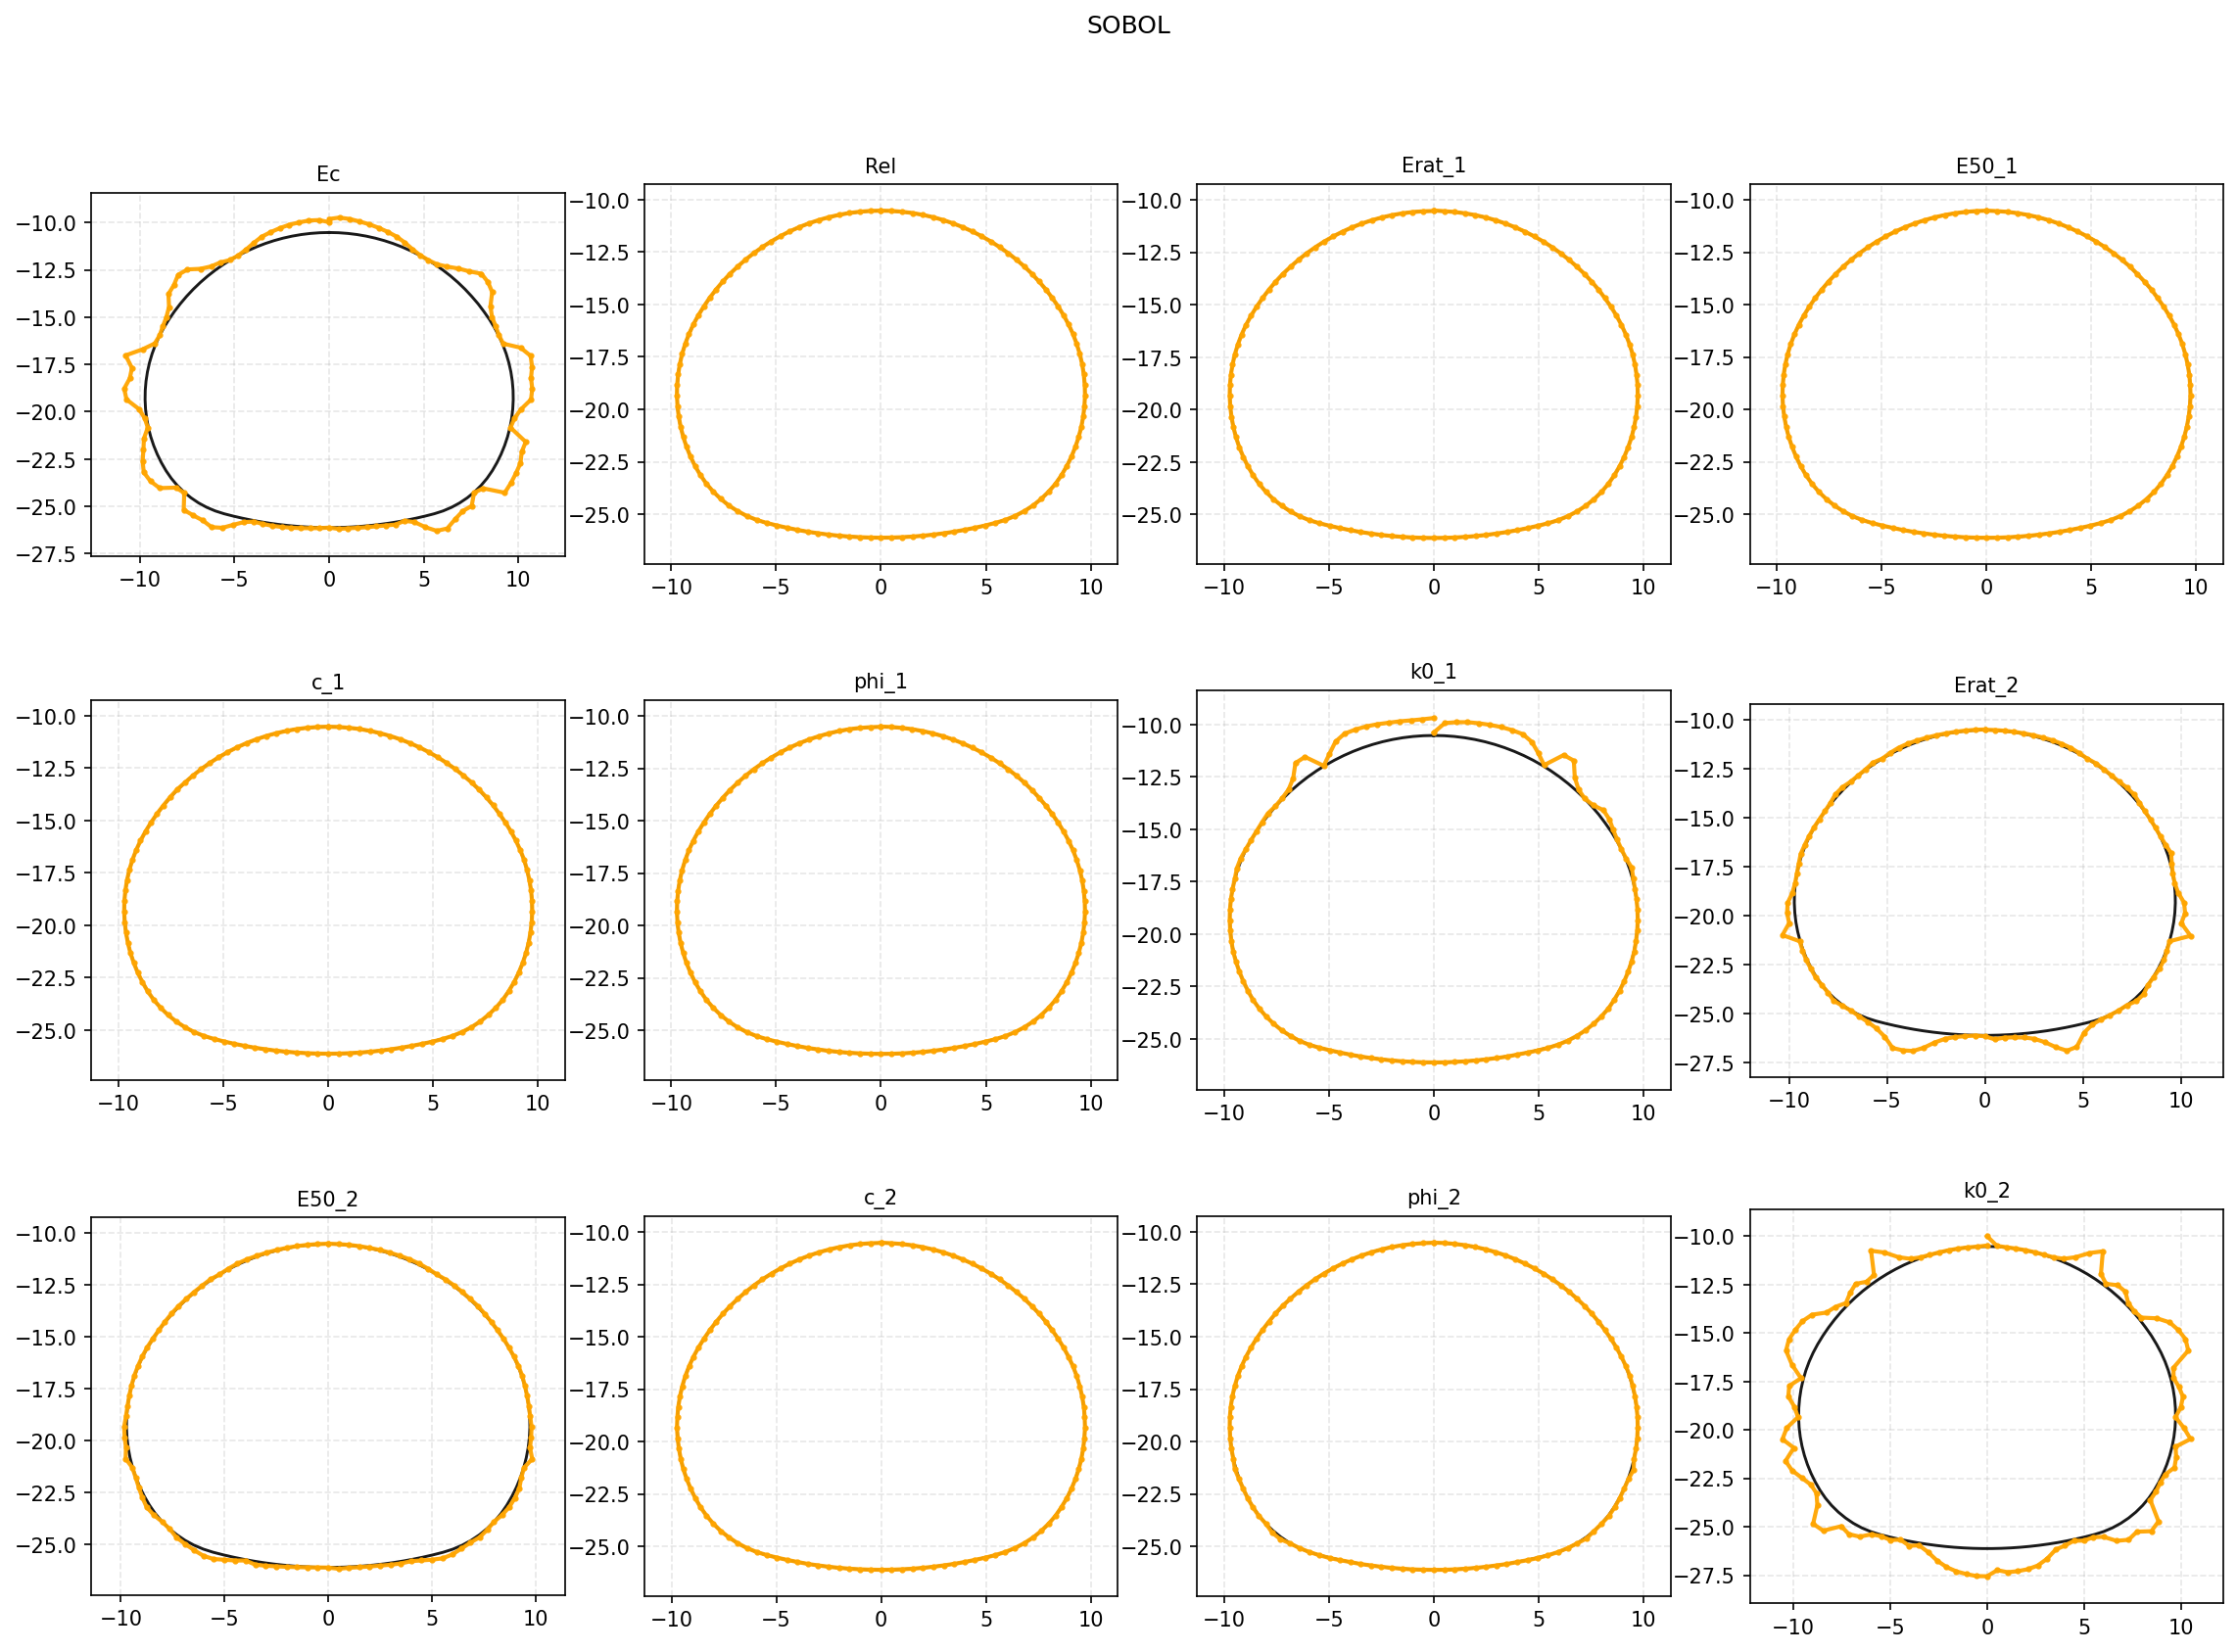

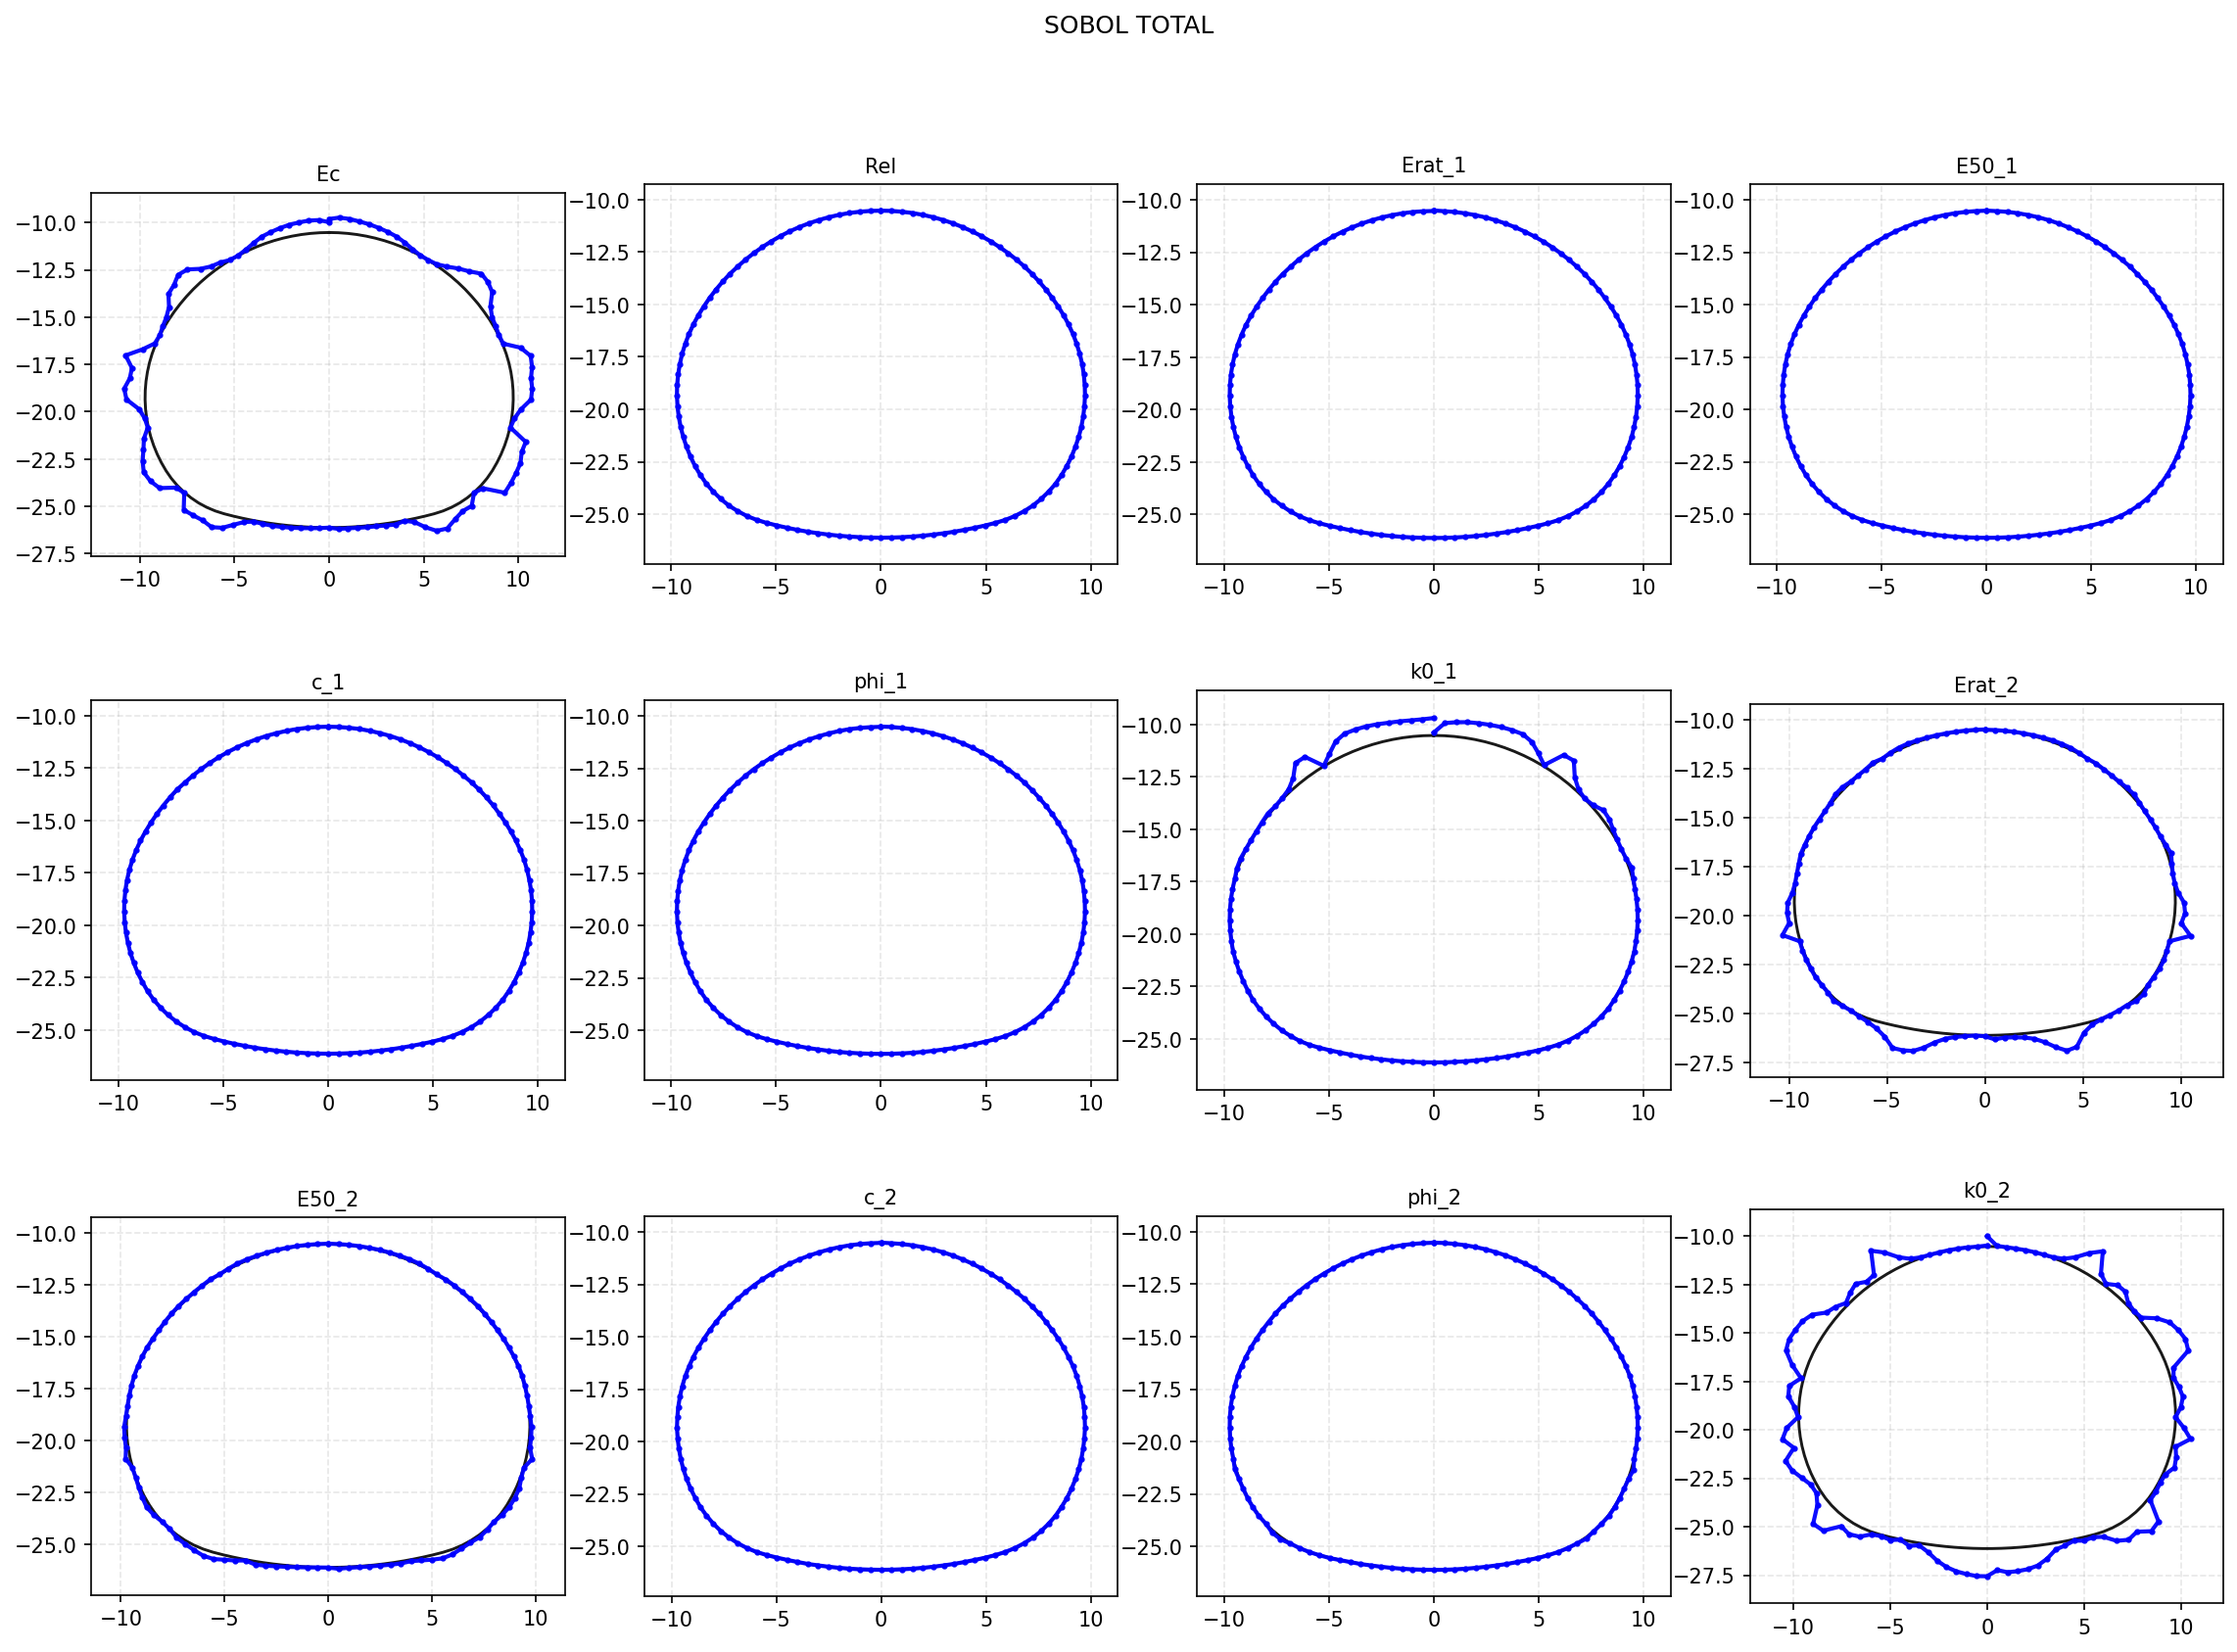

Hotovo.
Použité měřítko vychýlení: 1.496 jednotek na 1.0 index


In [51]:


# NASTAVENÍ
CSV_PATH = "V_mean_results.csv"    
INCLUDE_KEYS: list[str] = []        

# Měřítko vychýlení hodnot od osy
SCALE_VALUE_AUTO = True
SCALE_VALUE_MANUAL = 1.0              
CLIP_TO_01 = True                    
POWER_GAMMA = 1.0             

# Výstupy
DIR_S1 = "out_s1"
DIR_ST = "out_st"
GRID_S1 = "grids_s1"
GRID_ST = "grids_st"
GRID_COLS, GRID_ROWS = 4, 3
SHOW_GRIDS = True                  

# Vzhled
LINEWIDTH_TUNNEL = 1.4
LINEWIDTH_FIELD_S1 = 2.0
LINEWIDTH_FIELD_ST = 2.0
COLOR_TUNNEL = "black"
COLOR_S1 = "orange"   # SOLO  oranžová
COLOR_ST = "blue"     # TOTAL modrá
MARKERSIZE_FIELD = 2.0
PAD = 0.08

def extract_position(name: str):     # poloha bodu na tunelu
    if not isinstance(name, str):
        return None
    m = re.search(r"x\s*=\s*([0-9]+[.,]?[0-9]*)", name, flags=re.IGNORECASE)
    if m:
        return float(m.group(1).replace(",", "."))
    m2 = re.findall(r"([0-9]+[.,]?[0-9]*)", name)
    if m2:
        val = m2[-1].replace(",", ".")
        return int(val) if re.fullmatch(r"[0-9]+", val) else float(val)
    return None

def maybe_filter_df(df: pd.DataFrame, keys: list[str]) -> pd.DataFrame:
    if not keys:
        return df
    mask = np.zeros(len(df), dtype=bool)
    col = df["column"].astype(str)
    for k in keys:
        mask |= col.str.contains(re.escape(k), case=False, na=False)
    return df.loc[mask].copy()

def ensure_closed(xy: np.ndarray) -> np.ndarray: #Uzavře tunel
    
    if np.allclose(xy[0], xy[-1]):
        return xy.copy()
    return np.vstack([xy, xy[0]])

def arclength_closed(xy: np.ndarray) -> tuple[np.ndarray, float]: #Uzavře tunel
    xy_c = ensure_closed(xy)
    seg = np.diff(xy_c, axis=0)             # včetně posledního - první
    ds = np.sqrt((seg**2).sum(1))
    s = np.concatenate([[0.0], np.cumsum(ds)])
    L = float(s[-1])
    return s[:-1], L

def tangent_normals_closed(xy: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    n = len(xy)
    t = np.roll(xy, -1, axis=0) - np.roll(xy, 1, axis=0)
    norms = np.linalg.norm(t, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    t = t / norms
    nrm = np.column_stack((-t[:,1], t[:,0]))
    nrm /= np.maximum(np.linalg.norm(nrm, axis=1, keepdims=True), 1e-12)
    return t, nrm

def interp_along_closed_polyline(xy: np.ndarray, s_query: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    s_nodes, L = arclength_closed(xy)
    t, nrm = tangent_normals_closed(xy)
    s_q = np.mod(s_query, L)
    x = np.empty((len(s_q), 2), dtype=float)
    n = np.empty((len(s_q), 2), dtype=float)
    # interp mezi uzly 0..n-1
    x[:,0] = np.interp(s_q, s_nodes, xy[:,0])
    x[:,1] = np.interp(s_q, s_nodes, xy[:,1])
    n[:,0] = np.interp(s_q, s_nodes, nrm[:,0])
    n[:,1] = np.interp(s_q, s_nodes, nrm[:,1])
    norms = np.linalg.norm(n, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    n /= norms
    return x, n

def normalize_01(a: np.ndarray) -> np.ndarray:
    amin, amax = np.nanmin(a), np.nanmax(a)
    if not np.isfinite(amin) or not np.isfinite(amax) or abs(amax-amin) < 1e-12:
        return np.zeros_like(a)
    return (a - amin) / (amax - amin)

def value_transform(v: np.ndarray) -> np.ndarray:
    v = np.asarray(v, dtype=float)
    if CLIP_TO_01:
        v = np.clip(v, 0.0, 1.0)
    if POWER_GAMMA != 1.0:
        v = np.power(v, POWER_GAMMA)
    return v

def autoscale_value(nodes_xy: np.ndarray) -> float: #automatické měšřítko
    xmin, ymin = nodes_xy.min(axis=0)
    xmax, ymax = nodes_xy.max(axis=0)
    diag = math.hypot(xmax-xmin, ymax-ymin)
    return 0.06 * diag

def plot_one(ax, xy, disp_s1=None, disp_st=None, title=None):
    xy_closed = ensure_closed(xy)
    ax.plot(xy_closed[:,0], xy_closed[:,1],
            linewidth=LINEWIDTH_TUNNEL, color=COLOR_TUNNEL, alpha=0.9)  # tunel (uzavřeně)
    # ST křivka – SVĚTLE ZELENÁ
    if disp_st is not None:
        ax.plot(disp_st[:,0], disp_st[:,1],
                linewidth=LINEWIDTH_FIELD_ST, marker="o", markersize=MARKERSIZE_FIELD,
                color=COLOR_ST, alpha=0.95, label="ST")
    # S1 křivka – základní barva
    if disp_s1 is not None:
        ax.plot(disp_s1[:,0], disp_s1[:,1],
                linewidth=LINEWIDTH_FIELD_S1, marker="o", markersize=MARKERSIZE_FIELD,
                color=COLOR_S1, alpha=0.95, label="S1")

    ax.set_aspect("equal", adjustable="box")
 
    xs = [xy_closed[:,0]]
    ys = [xy_closed[:,1]]
    if disp_s1 is not None:
        xs.append(disp_s1[:,0]); ys.append(disp_s1[:,1])
    if disp_st is not None:
        xs.append(disp_st[:,0]); ys.append(disp_st[:,1])
    xmin, xmax = np.min(np.concatenate(xs)), np.max(np.concatenate(xs))
    ymin, ymax = np.min(np.concatenate(ys)), np.max(np.concatenate(ys))
    dx, dy = xmax-xmin, ymax-ymin
    ax.set_xlim(xmin - PAD*dx, xmax + PAD*dx)
    ax.set_ylim(ymin - PAD*dy, ymax + PAD*dy)
    if title:
        ax.set_title(title, fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.3)

# NAČTENÍ DAT
df = pd.read_csv(CSV_PATH)
if "column" not in df.columns:
    raise ValueError("V CSV chybí sloupec 'column'.")

df = maybe_filter_df(df, INCLUDE_KEYS)

df["xpos"] = df["column"].apply(extract_position)
if df["xpos"].isna().any():
    df.loc[df["xpos"].isna(), "xpos"] = np.arange(df["xpos"].isna().sum())

df = df.sort_values("xpos", kind="mergesort").reset_index(drop=True)

# detekuj páry S1,ST
s1_cols = [c for c in df.columns if c.startswith("S1_")]
st_cols = [c for c in df.columns if c.startswith("ST_")]
inputs = [c[3:] for c in s1_cols if f"ST_{c[3:]}" in st_cols]
if not inputs:
    raise ValueError("Nenašel jsem páry 'S1_*' a 'ST_*'.")

# uzavření tunelu
s_nodes, L = arclength_closed(nodes)
xpos = df["xpos"].to_numpy(dtype=float)
if np.all(np.isfinite(xpos)) and xpos.ptp() > 0:
    t01 = (xpos - xpos.min()) / (xpos.max() - xpos.min())
else:
    t01 = np.linspace(0.0, 1.0, len(df))
s_query = t01 * L

xyz, normals = interp_along_closed_polyline(nodes, s_query)

# měřítko vychýlení
SCALE_VALUE = autoscale_value(nodes) if SCALE_VALUE_AUTO else float(SCALE_VALUE_MANUAL)

os.makedirs(DIR_S1, exist_ok=True)
os.makedirs(DIR_ST, exist_ok=True)
os.makedirs(GRID_S1, exist_ok=True)
os.makedirs(GRID_ST, exist_ok=True)

plt.rcParams.update({"figure.dpi": 150})

# Jednolivé obr.
for name in inputs:
    v_s1 = value_transform(df[f"S1_{name}"].to_numpy(dtype=float))
    v_st = value_transform(df[f"ST_{name}"].to_numpy(dtype=float))

    disp_s1 = xyz + normals * (v_s1[:, None] * SCALE_VALUE)
    disp_st = xyz + normals * (v_st[:, None] * SCALE_VALUE)

    #  S
    fig, ax = plt.subplots(figsize=(5.8, 5.8))
    plot_one(ax, nodes, disp_s1=disp_s1, disp_st=None, title=f"S1 – {name}")
    fig.tight_layout()
    fig.savefig(os.path.join(DIR_S1, f"S1_{name}.png"), dpi=300)
    plt.close(fig)

    # ST
    fig, ax = plt.subplots(figsize=(5.8, 5.8))
    plot_one(ax, nodes, disp_s1=None, disp_st=disp_st, title=f"ST – {name}")
    fig.tight_layout()
    fig.savefig(os.path.join(DIR_ST, f"ST_{name}.png"), dpi=300)
    plt.close(fig)

# MŘÍŽKY 4×3
n = len(inputs)
per_page = GRID_COLS * GRID_ROWS
pages = math.ceil(n / per_page)

for p in range(pages):
    start, end = p*per_page, min((p+1)*per_page, n)
    batch = inputs[start:end]

    fig, axes = plt.subplots(GRID_ROWS, GRID_COLS, figsize=(GRID_COLS*3.8, GRID_ROWS*3.8))
    axes = np.array(axes).reshape(GRID_ROWS, GRID_COLS)

    for i, name in enumerate(batch):
        ax = axes[i // GRID_COLS, i % GRID_COLS]
        v = value_transform(df[f"S1_{name}"].to_numpy(dtype=float))
        disp = xyz + normals * (v[:, None] * SCALE_VALUE)
        plot_one(ax, nodes, disp_s1=disp, disp_st=None, title=name)

    for j in range(len(batch), per_page):
        axes[j // GRID_COLS, j % GRID_COLS].axis("off")

    fig.suptitle(f"SOBOL", y=0.995, fontsize=12)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    outp = os.path.join(GRID_S1, f"S1_grid_{p+1}.png")
    fig.savefig(outp, dpi=300)
    if SHOW_GRIDS: plt.show()
    else: plt.close(fig)

# MŘÍŽKY 4×3
for p in range(pages):
    start, end = p*per_page, min((p+1)*per_page, n)
    batch = inputs[start:end]

    fig, axes = plt.subplots(GRID_ROWS, GRID_COLS, figsize=(GRID_COLS*3.8, GRID_ROWS*3.8))
    axes = np.array(axes).reshape(GRID_ROWS, GRID_COLS)

    for i, name in enumerate(batch):
        ax = axes[i // GRID_COLS, i % GRID_COLS]
        v = value_transform(df[f"ST_{name}"].to_numpy(dtype=float))
        disp = xyz + normals * (v[:, None] * SCALE_VALUE)
        # v mřížce ST vykreslíme jen ST (zeleně)
        plot_one(ax, nodes, disp_s1=None, disp_st=disp, title=name)

    for j in range(len(batch), per_page):
        axes[j // GRID_COLS, j % GRID_COLS].axis("off")

    fig.suptitle(f"SOBOL TOTAL", y=0.995, fontsize=12)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    outp = os.path.join(GRID_ST, f"ST_grid_{p+1}.png")
    fig.savefig(outp, dpi=300)
    if SHOW_GRIDS: plt.show()
    else: plt.close(fig)

print("Hotovo.")
print(f"Použité měřítko vychýlení: {autoscale_value(nodes) if SCALE_VALUE_AUTO else SCALE_VALUE_MANUAL:.3f} jednotek na 1.0 index")


### Vykresleni vnitrnich sil

mean_mean_PCE (bez dělení):
[   1069.48330908    -670.08255299   -3460.73292039   -7942.53235448
  -14604.68039238  -23676.85476958  -35156.64778282  -48704.04005607
  -63000.18809067  -75751.50315952  -79639.78761803  -64160.18635914
   28200.85409566  115444.47551685  122983.52923213   94193.45487019
   56190.22188978   28151.86892046   15999.11840048   17794.90060244
   30131.73815908   32216.83905873   20694.66037865    9763.30311501
   -2223.48069801  -15135.01489915  -29712.40038543  -44420.2626154
  -58735.06435286  -72466.28706602  -82639.63653247  -80847.73459317
     911.16404654  102400.65965257   83863.48136587   72886.59318097
   71742.26384486   59139.5479148    32780.27865848   15506.91807745
    -771.04909731  -26418.71265649  -58424.38091427  -94434.09618149
 -134457.25937508 -132534.46225585  -91216.74622421  -47943.4726442
    8170.93319789   82293.27324958   82507.5070565    74434.55237093
   61295.11559592   45701.62200477   29898.07283011   13747.83634705
   -2726

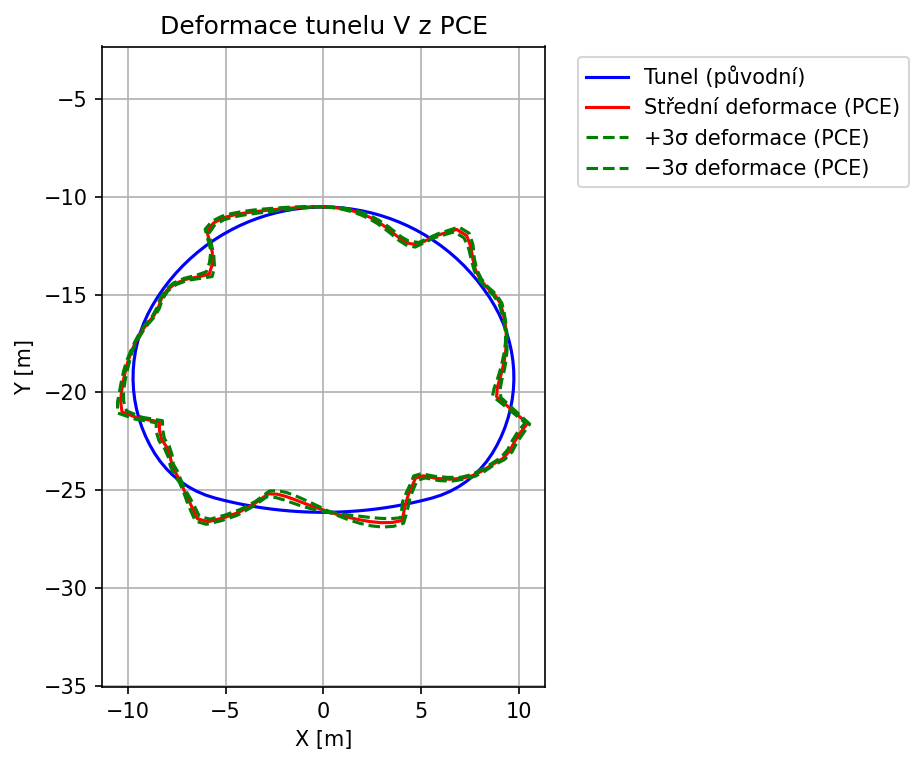

In [50]:
MEAN_RESULTS_CSV = "V_mean_results.csv"   # PCE výsledků
NODES_CSV= "nodes.csv"            #souřadnice tunelu (X,Y)
HAS_HEADER= True 
SAVE_PNG= False          
PNG_NAME= "PCE_deformace_mean_pm_3sigma.png"
mean_results = pd.read_csv(MEAN_RESULTS_CSV)


Fmultiplier_raw = mean_results["mean_mean_PCE"].to_numpy()
std_Fmultiplier_raw = mean_results["mean_std_PCE"].to_numpy()

print("mean_mean_PCE (bez dělení):")
print(Fmultiplier_raw)
print("\nPmean_std_PCE (bez dělení):")
print(std_Fmultiplier_raw)

Fmultiplier = mean_results["mean_mean_PCE"].to_numpy()/100000
std_Fmultiplier = mean_results["mean_std_PCE"].to_numpy()/100000


#  radiální deformace od středu 
center = nodes.mean(axis=0)

def deform_nodes(nodes_arr, delta_arr):
    out = np.zeros_like(nodes_arr, dtype=float)
    for i in range(len(nodes_arr)):
        v = nodes_arr[i] - center
        n = np.linalg.norm(v)
        out[i] = nodes_arr[i] + (delta_arr[i] * (v / n) if n != 0 else 0.0)
    return out

axialF_mean   = deform_nodes(nodes, Fmultiplier)
axialF_plus3  = deform_nodes(nodes, Fmultiplier + 3.0 * std_Fmultiplier)
axialF_minus3 = deform_nodes(nodes, Fmultiplier - 3.0 * std_Fmultiplier)

plt.figure(figsize=(16.5 / 2.54, 5.2))

# Tunel a deformace
plt.plot(nodes[:, 0],        nodes[:, 1],        'b-',  label='Tunel (původní)')
plt.plot(axialF_mean[:, 0],  axialF_mean[:, 1],  'r-',  label='Střední deformace (PCE)')
plt.plot(axialF_plus3[:, 0], axialF_plus3[:, 1], 'g--', label='+3σ deformace (PCE)')
plt.plot(axialF_minus3[:, 0], axialF_minus3[:, 1], 'g--', label='−3σ deformace (PCE)')

# Spojení horního bodu
plt.plot([nodes[-1, 0],        nodes[0, 0]],        [nodes[-1, 1],        nodes[0, 1]],        'b-')
plt.plot([axialF_mean[-1, 0],  axialF_mean[0, 0]],  [axialF_mean[-1, 1],  axialF_mean[0, 1]],  'r-')
plt.plot([axialF_plus3[-1, 0], axialF_plus3[0, 0]], [axialF_plus3[-1, 1], axialF_plus3[0, 1]], 'g--')
plt.plot([axialF_minus3[-1, 0], axialF_minus3[0, 0]], [axialF_minus3[-1, 1], axialF_minus3[0, 1]], 'g--')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Deformace tunelu V z PCE')
plt.grid(True)
plt.axis('equal')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

if SAVE_PNG:
    plt.savefig(PNG_NAME, dpi=200)
plt.show()
